In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=2)
sns.set_style("whitegrid")
np.seterr(divide='ignore');

# GPS Application: N-D Newton's Method
Global Positioning System (GPS) uses 4 satellites to calculate the location of a GPS receiver on earth.  We construct a $xyz$-coordinate system, with the origin located at the center of the Earth.  Relative to this coordinate system, each satellite $i$ has position $(A_i,B_i,C_i)$.  In addition to this, each satellite keeps track of time relative to some reference value, which is denoted $t_i$.

Here we define the values for 4 satellites using the rows of a `numpy`array.  $A_i$, $B_i$ and $C_i$ are measured in kilometers, and $t_i$ is measured in seconds:

In [2]:
Satellites = np.array([[15600, 7540, 20140, 0.07074],
                      [18760, 2750, 18610, 0.07220],
                      [17610, 14630, 13480, 0.07690],
                      [19170, 610, 18390, 0.07242]])

In [3]:
print(Satellites[0])

[1.560e+04 7.540e+03 2.014e+04 7.074e-02]


We can plot the satellites in 3D, along with a sphere of radius 6370 km (approximately the radius of the Earth).

In [4]:
# import 3d plotting
from mpl_toolkits.mplot3d import Axes3D

# data for sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

# multiply by 6370 km
x = 6370*np.outer(np.cos(u), np.sin(v))
y = 6370*np.outer(np.sin(u), np.sin(v))
z = 6370*np.outer(np.ones(np.size(u)), np.cos(v))

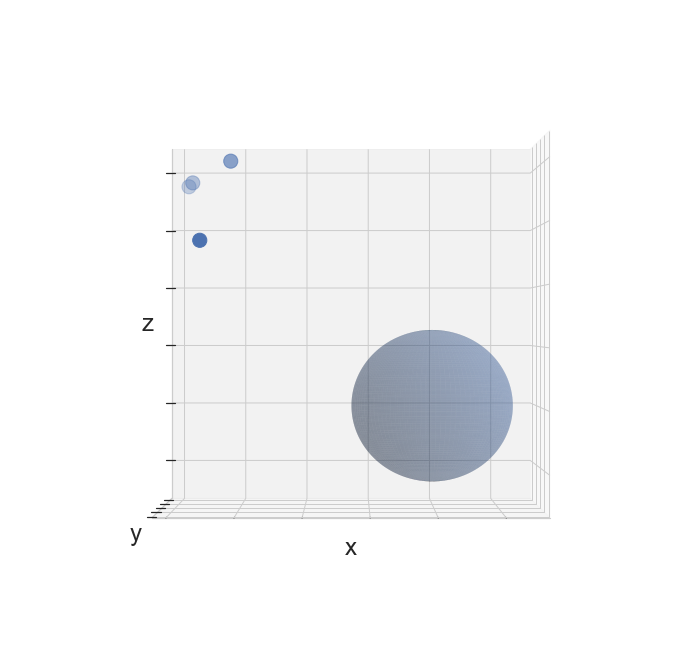

In [5]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111,projection='3d')

ax.scatter(Satellites[:,0],Satellites[:,1], Satellites[:,2],s = 200)
ax.plot_surface(x, y, z, color='b',alpha = 0.3,rstride = 1,cstride = 1,linewidth = 0.0,zorder = 10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.axes.zaxis.set_ticklabels([])
ax.view_init(0,90)
plt.show()

The receiver on Earth has $xyz$ coordinates of it's own, as well as a time delay $d$ that measures the difference between its clock and the reference time.  In order to **solve for the location of the receiver** and measure it's delay, four nonlinear equations must be solved:

$F_i(\mathbf{X}) = F_i(x,y,z,d) = \sqrt{(x - A_i)^2 + (y - B_i)^2 + (z - C_i)^2} - c(t_i - d),\hspace{7mm} \text{for  } i=1,2,3,4$

Here, $c$ is the speed of light, 299792.456 km/s.  Then we want to solve the nonlinear system of equations

$\mathbf{F}(\mathbf{X}) = \mathbf{0}$,

where $\mathbf{F}(\mathbf{X}) = (F_1(\mathbf{X}),F_2(\mathbf{X}),F_3(\mathbf{X}),F_4(\mathbf{X}))^T$ and $\mathbf{X} = (x,y,z,d)^T$.

### Newton's Method
To solve the equations, we can start with an initial guess $\mathbf{X}_0$ and compute a sequence of approximate solutions by Newton's method:

$\mathbf{J}(\mathbf{X})\mathbf{S}_k = -\mathbf{F}(\mathbf{X})$

$\mathbf{X}_{k+1} = \mathbf{X}_k + \mathbf{S}_k$

$\mathbf{J}(\mathbf{X})$ is the Jacobian of $\mathbf{F}$ evaluated at $\mathbf{X}$ with entries given by $J_{ij} = \frac{\partial F_i}{\partial X_j}$.

For example, the partial derivative $\frac{\partial F_1}{\partial X_1} $ is given by:

$$\frac{\partial F_1}{\partial X_1} = \frac{\partial F_1}{\partial x} = \frac{x - A_1}{\sqrt{(x-A_1)^2 + (y - B_1)^2 + (z - C_1)^2}}$$

Write functions that compute both $\mathbf{F}$ and $\mathbf{J}$.

```python
def f(X):
    # X: 1d numpy array with shape (4,) with the variables (x,y,z,d)
    # Compute each nonlinear equation F_i
    # F: 1d numpy array F with shape (4,) with each entry F_i
    return F

def J(X):
    # X: 1d numpy array with shape (4,) with the variables (x,y,z,d)
    # J: 2d numpy array F with shape (4,4) with the partial derivatives dF_i / dX_j
    return J
```

In [6]:
c = 299792.458

In [7]:
#grade_clear
def f(X):
    x,y,z,d = X
    A = Satellites[:,0]
    B = Satellites[:,1]
    C = Satellites[:,2]
    t = Satellites[:,3]
    
    return np.sqrt((x - A)**2 + (y-B)**2 + (z - C)**2) - c*(t - d)

def J(X):
    x,y,z,d = X
    A = Satellites[:,0]
    B = Satellites[:,1]
    C = Satellites[:,2]
    t = Satellites[:,3]
    
    D = np.zeros((4,4))
    denom = np.sqrt((x - A)**2 + (y-B)**2 + (z - C)**2)
    D[:,0] = (x - A)/denom
    D[:,1] = (y - B)/denom
    D[:,2] = (z - C)/denom
    D[:,3] = c
    return D

Let's use an initial guess of a receiver at the South Pole with no time delay: $\mathbf{X}_0 = (0,0,-6370,0)^T$.  We will also store this initial guess in the list `X_hist` where we will store all the updates for `X`.

In [8]:
X = np.array([6370,0,0,0])
X_hist = [X]

In [11]:
J(X)

array([[-3.94406955e-01, -3.22191597e-01, -8.60601957e-01,
         2.99792458e+05],
       [-5.50038650e-01, -1.22082832e-01, -8.26167819e-01,
         2.99792458e+05],
       [-4.91921433e-01, -6.40285637e-01, -5.89955597e-01,
         2.99792458e+05],
       [-5.71062101e-01, -2.72146783e-02, -8.20455628e-01,
         2.99792458e+05]])

Starting from this guess, use Newton's method to locate the receiver on Earth. 

Store each updated `X` using `X_hist.append(X)`. 

Terminate the iterative process when $\|\mathbf{F}(\mathbf{X})\|_2 < 10^{-3}$.

In [9]:
#grade_clear
for i in range(30):
    A = J(X)
    b = -f(X)
    if np.linalg.norm(b) < 1e-3:
        break
    s = np.linalg.solve(A,b)
    X = X + s
    X_hist.append(X)

In [10]:
X_hist

[array([6370,    0,    0,    0]),
 array([-8.42291082e+02, -1.00048881e+02,  6.15061223e+03,  7.38879433e-04]),
 array([-1.46849093e+01, -1.39153223e+01,  6.37640112e+03, -3.10903330e-03]),
 array([-4.17425451e+01, -1.67859485e+01,  6.37006538e+03, -3.20146369e-03]),
 array([-4.17727095e+01, -1.67891941e+01,  6.37005956e+03, -3.20156583e-03])]

You can run this next cell to plot **the position of the receiver** for the first 3 steps:

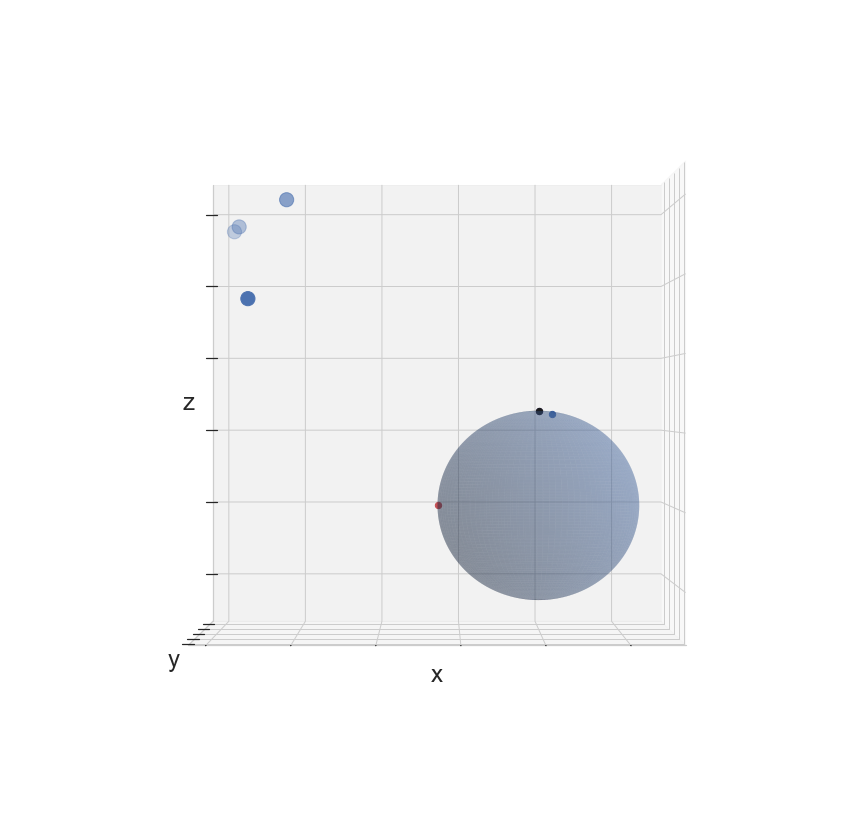

In [17]:
X0 = X_hist[0]
X1 = X_hist[1]
X2 = X_hist[2]
X3 = X_hist[3]

x = 6370*np.outer(np.cos(u), np.sin(v))
y = 6370*np.outer(np.sin(u), np.sin(v))
z = 6370*np.outer(np.ones(np.size(u)), np.cos(v))

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111,projection='3d')
# Plot the surface
ax.scatter(Satellites[:,0],Satellites[:,1], Satellites[:,2],s = 200)
ax.plot_surface(x, y, z, color='b',alpha = 0.3,rstride = 1,cstride = 1,linewidth = 0.0,zorder = 10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(0,90)
ax.scatter(X0[0],X0[1], X0[2],s=40,color='r',alpha = 1,zorder = 0)
ax.scatter(X1[0],X1[1], X1[2],s=40,color='b',alpha = 1,zorder = 0)
ax.scatter(X2[0],X2[1], X2[2],s=40,color='k',alpha = 1,zorder = 0)
ax.scatter(X3[0],X3[1], X3[2],s=40,color='m',alpha = 1,zorder = 0)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.axes.zaxis.set_ticklabels([])
plt.show()